This code will run the DistilBert with and withouit Class Weights using the save model. The Kfold part will be here also, because it need to use GPU to run to get the faster result compared to using CPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/My Drive/SMC2/Augmented_Sentiment_data.csv'
data2 = pd.read_csv(file_path)

# Preview
data2.head()

,Restaurant,Reviewer,Review,Rating,Time,VADER_Score,Sentiment
0,Beyond Flavours,Rusha Chakraborty,ambience good food quite good saturday lunch c...,5.0,2019-05-25 15:54:00,0.9664,2
1,Beyond Flavours,Anusha Tirumalaneedi,ambience good pleasant evening service prompt ...,5.0,2019-05-25 14:20:00,0.9360,2
2,Beyond Flavours,Ashok Shekhawat,must try great food great ambience thnx servic...,5.0,2019-05-24 22:54:00,0.9186,2
3,Beyond Flavours,Swapnil Sarkar,soumen da arun great guy behavior sincerety go...,5.0,2019-05-24 22:11:00,0.8591,2
4,Beyond Flavours,Dileep,food goodwe ordered kodi drumstick basket mutt...,5.0,2019-05-24 21:37:00,0.9201,2


In [3]:
!cp "/content/drive/MyDrive/SMC2/distilbert_basic_sentiment_model.zip" .
!unzip distilbert_basic_sentiment_model.zip

Archive:  distilbert_basic_sentiment_model.zip
   creating: distilbert_basic_sentiment_model/
  inflating: distilbert_basic_sentiment_model/config.json  
  inflating: distilbert_basic_sentiment_model/model.safetensors  
  inflating: distilbert_basic_sentiment_model/special_tokens_map.json  
  inflating: distilbert_basic_sentiment_model/tokenizer_config.json  
  inflating: distilbert_basic_sentiment_model/vocab.txt  


In [4]:
!cp "/content/drive/MyDrive/SMC2/distilbert_weighted_sentiment_model.zip" .
!unzip distilbert_weighted_sentiment_model.zip

Archive:  distilbert_weighted_sentiment_model.zip
   creating: distilbert_weighted_sentiment_model/
  inflating: distilbert_weighted_sentiment_model/config.json  
  inflating: distilbert_weighted_sentiment_model/model.safetensors  
  inflating: distilbert_weighted_sentiment_model/special_tokens_map.json  
  inflating: distilbert_weighted_sentiment_model/tokenizer_config.json  
  inflating: distilbert_weighted_sentiment_model/vocab.txt  


## Transformer

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [6]:
!pip install transformers

In [7]:
!pip install -q transformers

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

### Call the save model

In [9]:
# Load Basic Trained Model
model_basic = DistilBertForSequenceClassification.from_pretrained("distilbert_basic_sentiment_model").to(device)
tokenizer_basic = DistilBertTokenizer.from_pretrained("distilbert_basic_sentiment_model")
model_basic.eval() # Set model to evaluation mode

# Load Weighted Class Model
model_class_weight = DistilBertForSequenceClassification.from_pretrained("distilbert_weighted_sentiment_model").to(device)
tokenizer_weighted = DistilBertTokenizer.from_pretrained("distilbert_weighted_sentiment_model")
model_class_weight.eval()

print("Models loaded successfully!")

Models loaded successfully!


In [10]:
# Train-test split (stratified by Sentiment)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data2['Review'].astype(str).tolist(),
    data2['Sentiment'].tolist(),
    test_size=0.2,
    stratify=data2['Sentiment'],
    random_state=42
)

# Check the number of samples in each set
len(train_texts), len(test_texts)

(10517, 2630)

#### Tokenize Using BERT Tokenizer

In [11]:
# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Confirm tokenization keys
train_encodings.keys()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

dict_keys(['input_ids', 'attention_mask'])

###  Create a PyTorch Dataset Class

In [12]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

# Preview one sample
train_dataset[0]

{'input_ids': tensor([ 101, 2081, 4248, 8974, 1012,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

### Build DataLoaders

In [13]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Show number of batches
len(train_loader), len(test_loader)

(1315, 329)

In [14]:
# Evaluation
print("\nEvaluating model on test set...")
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_basic(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


Evaluating model on test set...


Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.87      0.84       899
     Neutral       0.63      0.50      0.56       477
    Positive       0.89      0.92      0.91      1254

    accuracy                           0.83      2630
   macro avg       0.78      0.76      0.77      2630
weighted avg       0.82      0.83      0.82      2630



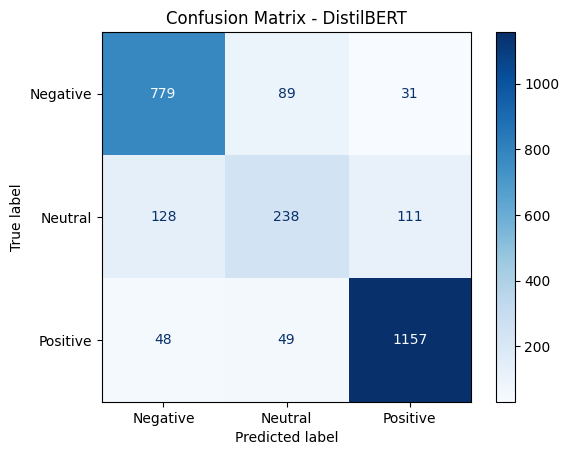

In [26]:
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - DistilBERT")
plt.show()

### DistilBert with Class Weights

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tokenize test data using tokenizer_weighted
test_encodings_weighted = tokenizer_weighted(test_texts, truncation=True, padding=True, max_length=128)

# Create dataset using the same class structure
test_dataset_weighted = ReviewDataset(test_encodings_weighted, test_labels)

# Create DataLoader
test_loader_weighted = DataLoader(test_dataset_weighted, batch_size=8)

In [17]:
# Run evaluation
model_class_weight.eval()
predictions_weighted = []
true_labels_weighted = []

with torch.no_grad():
    for batch in test_loader_weighted:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_class_weight(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions_weighted.extend(preds.cpu().numpy())
        true_labels_weighted.extend(labels.cpu().numpy())


Classification Report (Weighted Class Model):
              precision    recall  f1-score   support

    Negative       0.92      0.75      0.83       899
     Neutral       0.52      0.75      0.61       477
    Positive       0.91      0.87      0.89      1254

    accuracy                           0.81      2630
   macro avg       0.78      0.79      0.78      2630
weighted avg       0.84      0.81      0.82      2630



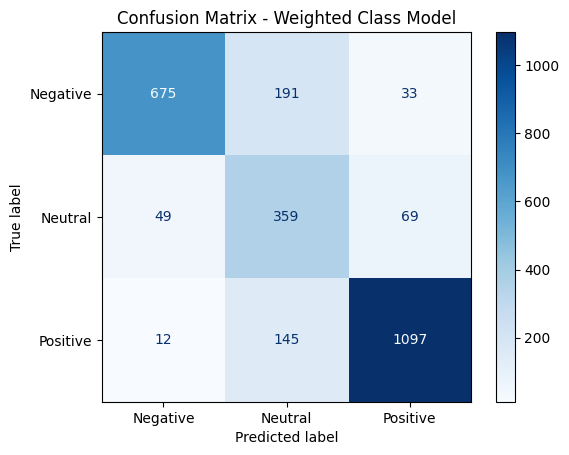

In [18]:
# Show classification report
print("\nClassification Report (Weighted Class Model):")
print(classification_report(true_labels_weighted, predictions_weighted, target_names=["Negative", "Neutral", "Positive"]))

# Show confusion matrix
cm_weighted = confusion_matrix(true_labels_weighted, predictions_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=["Negative", "Neutral", "Positive"])
disp_weighted.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Weighted Class Model")
plt.show()

### K fold cross validation

In [21]:
pip install wandb

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
import torch
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

Starting 5-Fold Cross-Validation...

Fold 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-26-1855230800.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'loss': 0.7591, 'grad_norm': 10.728137016296387, 'learning_rate': 4.2094423320659065e-05, 'epoch': 0.4752851711026616}
{'loss': 0.6462, 'grad_norm': 5.71121072769165, 'learning_rate': 3.417300380228137e-05, 'epoch': 0.9505703422053232}
{'loss': 0.5125, 'grad_norm': 4.397486209869385, 'learning_rate': 2.6251584283903673e-05, 'epoch': 1.4258555133079849}
{'loss': 0.4789, 'grad_norm': 10.410895347595215, 'learning_rate': 1.8330164765525983e-05, 'epoch': 1.9011406844106464}
{'loss': 0.3656, 'grad_norm': 2.439488410949707, 'learning_rate': 1.040874524714829e-05, 'epoch': 2.376425855513308}
{'loss': 0.3083, 'grad_norm': 0.40557628870010376, 'learning_rate': 2.487325728770596e-06, 'epoch': 2.8517110266159698}
{'train_runtime': 316.1281, 'train_samples_per_second': 79.838, 'train_steps_per_second': 9.983, 'train_loss': 0.5010209621434278, 'epoch': 3.0}
Fold 1 F1-score: 0.8115
              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83       720
     Neut

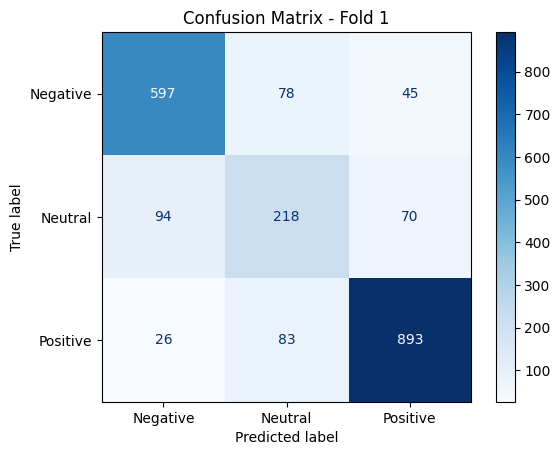


Fold 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-26-1855230800.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'loss': 0.7716, 'grad_norm': 4.59743070602417, 'learning_rate': 4.2094423320659065e-05, 'epoch': 0.4752851711026616}
{'loss': 0.6467, 'grad_norm': 6.146264553070068, 'learning_rate': 3.417300380228137e-05, 'epoch': 0.9505703422053232}
{'loss': 0.5268, 'grad_norm': 7.449601650238037, 'learning_rate': 2.6251584283903673e-05, 'epoch': 1.4258555133079849}
{'loss': 0.482, 'grad_norm': 13.40373420715332, 'learning_rate': 1.8330164765525983e-05, 'epoch': 1.9011406844106464}
{'loss': 0.392, 'grad_norm': 10.54526424407959, 'learning_rate': 1.040874524714829e-05, 'epoch': 2.376425855513308}
{'loss': 0.3334, 'grad_norm': 16.355911254882812, 'learning_rate': 2.487325728770596e-06, 'epoch': 2.8517110266159698}
{'train_runtime': 316.6547, 'train_samples_per_second': 79.705, 'train_steps_per_second': 9.967, 'train_loss': 0.5167458247775814, 'epoch': 3.0}
Fold 2 F1-score: 0.8139
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.84       719
     Neutral  

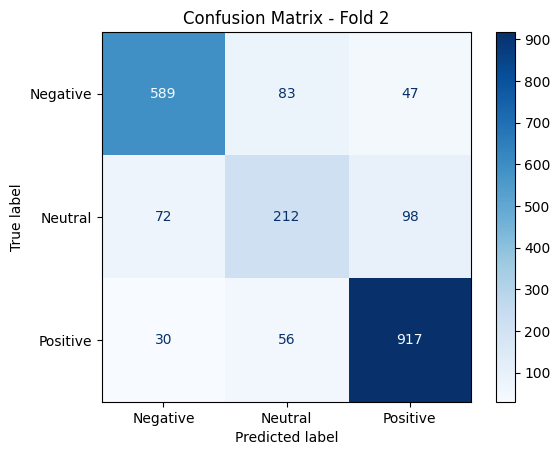


Fold 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-26-1855230800.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'loss': 0.7289, 'grad_norm': 7.079201698303223, 'learning_rate': 4.2094423320659065e-05, 'epoch': 0.4752851711026616}
{'loss': 0.6597, 'grad_norm': 9.131046295166016, 'learning_rate': 3.417300380228137e-05, 'epoch': 0.9505703422053232}
{'loss': 0.5309, 'grad_norm': 3.7237439155578613, 'learning_rate': 2.6251584283903673e-05, 'epoch': 1.4258555133079849}
{'loss': 0.4927, 'grad_norm': 6.844202041625977, 'learning_rate': 1.8330164765525983e-05, 'epoch': 1.9011406844106464}
{'loss': 0.3697, 'grad_norm': 3.7737843990325928, 'learning_rate': 1.040874524714829e-05, 'epoch': 2.376425855513308}
{'loss': 0.3683, 'grad_norm': 15.24009895324707, 'learning_rate': 2.487325728770596e-06, 'epoch': 2.8517110266159698}
{'train_runtime': 311.6417, 'train_samples_per_second': 80.997, 'train_steps_per_second': 10.127, 'train_loss': 0.5160887818523837, 'epoch': 3.0}
Fold 3 F1-score: 0.8234
              precision    recall  f1-score   support

    Negative       0.85      0.85      0.85       719
     Neut

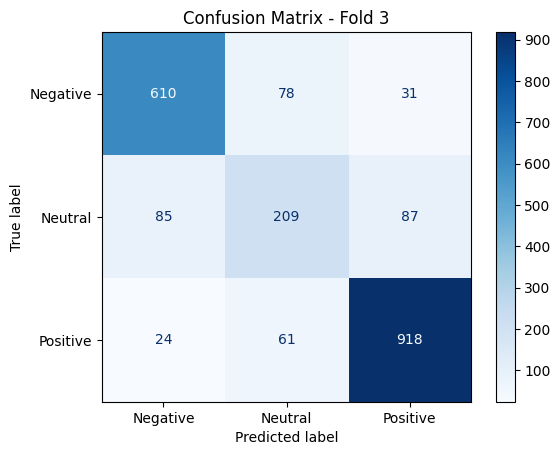


Fold 4


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-26-1855230800.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'loss': 0.7362, 'grad_norm': 9.44447135925293, 'learning_rate': 4.2094423320659065e-05, 'epoch': 0.4752851711026616}
{'loss': 0.6586, 'grad_norm': 10.51667308807373, 'learning_rate': 3.417300380228137e-05, 'epoch': 0.9505703422053232}
{'loss': 0.5333, 'grad_norm': 1.1289831399917603, 'learning_rate': 2.6251584283903673e-05, 'epoch': 1.4258555133079849}
{'loss': 0.509, 'grad_norm': 14.917139053344727, 'learning_rate': 1.8330164765525983e-05, 'epoch': 1.9011406844106464}
{'loss': 0.3766, 'grad_norm': 24.408859252929688, 'learning_rate': 1.040874524714829e-05, 'epoch': 2.376425855513308}
{'loss': 0.3354, 'grad_norm': 0.2060266137123108, 'learning_rate': 2.487325728770596e-06, 'epoch': 2.8517110266159698}
{'train_runtime': 309.5118, 'train_samples_per_second': 81.554, 'train_steps_per_second': 10.197, 'train_loss': 0.5164612249125394, 'epoch': 3.0}
Fold 4 F1-score: 0.8225
              precision    recall  f1-score   support

    Negative       0.83      0.85      0.84       719
     Neut

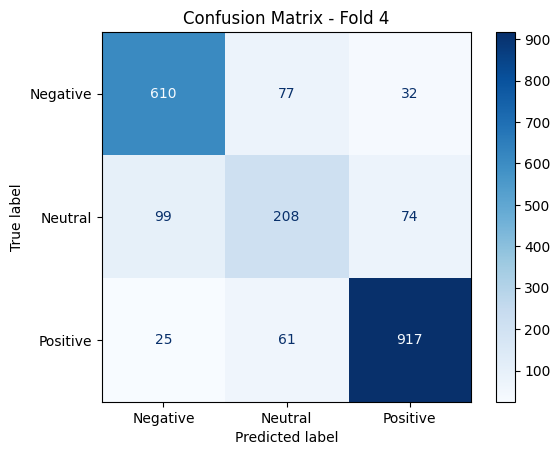


Fold 5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-26-1855230800.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'loss': 0.7631, 'grad_norm': 15.550700187683105, 'learning_rate': 4.2094423320659065e-05, 'epoch': 0.4752851711026616}
{'loss': 0.6393, 'grad_norm': 7.710855960845947, 'learning_rate': 3.417300380228137e-05, 'epoch': 0.9505703422053232}
{'loss': 0.4999, 'grad_norm': 1.5720787048339844, 'learning_rate': 2.6251584283903673e-05, 'epoch': 1.4258555133079849}
{'loss': 0.4831, 'grad_norm': 7.220623016357422, 'learning_rate': 1.8330164765525983e-05, 'epoch': 1.9011406844106464}
{'loss': 0.3741, 'grad_norm': 26.195703506469727, 'learning_rate': 1.040874524714829e-05, 'epoch': 2.376425855513308}
{'loss': 0.3246, 'grad_norm': 0.5985991358757019, 'learning_rate': 2.487325728770596e-06, 'epoch': 2.8517110266159698}
{'train_runtime': 309.695, 'train_samples_per_second': 81.506, 'train_steps_per_second': 10.191, 'train_loss': 0.5049070290588457, 'epoch': 3.0}
Fold 5 F1-score: 0.8091
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.84       719
     Neu

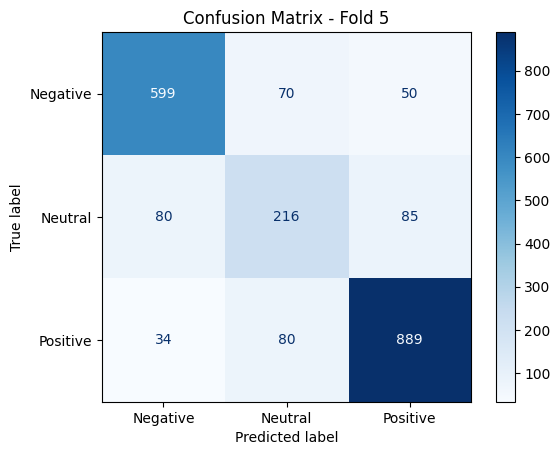


K-Fold Cross Validation Complete
Average F1-score over 5 folds: 0.8161


In [26]:
# Convert the tokenized dataset to list format for StratifiedKFold
input_ids = train_encodings['input_ids']
attention_mask = train_encodings['attention_mask']
labels = train_labels

# Prepare 5-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
f1_scores = []

print("Starting 5-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(input_ids, labels)):
    print(f"\nFold {fold+1}")

    # Split tokenized data
    train_inputs = {
        'input_ids': [input_ids[i] for i in train_idx],
        'attention_mask': [attention_mask[i] for i in train_idx],
        'labels': [labels[i] for i in train_idx]
    }
    val_inputs = {
        'input_ids': [input_ids[i] for i in val_idx],
        'attention_mask': [attention_mask[i] for i in val_idx],
        'labels': [labels[i] for i in val_idx]
    }

    # Convert to Hugging Face Dataset
    train_dataset = Dataset.from_dict(train_inputs)
    val_dataset = Dataset.from_dict(val_inputs)

    # Compute class weights for this fold
    fold_class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_inputs['labels']),
        y=train_inputs['labels']
    )
    fold_class_weights = torch.tensor(fold_class_weights, dtype=torch.float).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=fold_class_weights)

    # Load a fresh model for each fold
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)

    # Custom Trainer to inject class-weighted loss
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            return (loss, outputs) if return_outputs else loss

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold+1}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        logging_dir=f"./logs_fold_{fold+1}",
        save_strategy="no",
        disable_tqdm=True
    )

    import os
    os.environ["WANDB_DISABLED"] = "true"

    # Initialize Trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer
    )

    # Train the model on this fold
    trainer.train()

    # Evaluate on validation fold
    outputs = trainer.predict(val_dataset)
    preds = np.argmax(outputs.predictions, axis=1)
    true = outputs.label_ids

    # Classification report
    f1 = f1_score(true, preds, average='weighted')
    f1_scores.append(f1)
    print(f"Fold {fold+1} F1-score: {f1:.4f}")
    print(classification_report(true, preds, target_names=["Negative", "Neutral", "Positive"]))

    # Optional: Confusion matrix
    cm = confusion_matrix(true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

# Final average result
print("\nK-Fold Cross Validation Complete")
print(f"Average F1-score over {k} folds: {np.mean(f1_scores):.4f}")

Or if upload the zip on drive, then can run the code below:

- !cp /content/drive/MyDrive/SMC Project_2/distilbert_basic_sentiment_model.zip .
- !unzip distilbert_basic_sentiment_model.zip

In [28]:
import tabulate

# Create the table again as a clean summary DataFrame
summary_Kfold_table = pd.DataFrame({
    "Fold": ["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5", "Average"],
    "F1-Score": [0.8115, 0.8139, 0.8234, 0.8225, 0.8091, 0.8161]
})
summary_Kfold_table

,Fold,F1-Score
0,Fold 1,0.8115
1,Fold 2,0.8139
2,Fold 3,0.8234
3,Fold 4,0.8225
4,Fold 5,0.8091
5,Average,0.8161


## Hyperparameter
Bayesian Optimization using Optuna's Tree-structured Parzen Estimator (TPE)

In [19]:
!pip install optuna -q
!pip install transformers[torch] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.3 MB/s eta 0:00:00


In [20]:
import optuna
import os
from torch.nn import CrossEntropyLoss
from transformers import (
DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
)
from datasets import Dataset

In [31]:
# Prepare Tokenizer and Device
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize Data (required before training)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [32]:
# Model Init Function
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Evaluation Metric Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    f1 = f1_score(labels, preds, average='weighted')
    return {"f1": f1}

# Custom Weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = CrossEntropyLoss(weight=class_weights)  # or hy_class_weights
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Define Optuna Objective
def optuna_objective(trial):
    os.environ["WANDB_DISABLED"] = "true"  # Disable W&B logging

    training_args = TrainingArguments(
        output_dir="./optuna_results",
        per_device_train_batch_size=trial.suggest_categorical("batch_size", [8, 16]),
        learning_rate=trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        num_train_epochs=trial.suggest_int("epochs", 2, 5),
        weight_decay=trial.suggest_float("weight_decay", 0.0, 0.3),
        disable_tqdm=True,
        logging_dir="./logs"
    )

    trainer = WeightedTrainer(
        model_init=model_init,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_f1"]

In [33]:
# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(optuna_objective, n_trials=10)

# Show Best Parameters
print("\nBest Hyperparameters Found:")
print(study.best_params)

[I 2025-06-20 18:46:09,400] A new study created in memory with name: no-name-a5d3ab60-25a5-467d-b07c-aa3ae344c88e
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncas

{'loss': 0.7651, 'grad_norm': 6.729050159454346, 'learning_rate': 7.4749488297810594e-06, 'epoch': 0.7598784194528876}
{'loss': 0.5655, 'grad_norm': 12.395624160766602, 'learning_rate': 5.722733914220568e-06, 'epoch': 1.5197568389057752}
{'loss': 0.5037, 'grad_norm': 5.93122673034668, 'learning_rate': 3.970518998660075e-06, 'epoch': 2.2796352583586628}
{'loss': 0.4792, 'grad_norm': 7.6819586753845215, 'learning_rate': 2.218304083099583e-06, 'epoch': 3.0395136778115504}
{'loss': 0.4192, 'grad_norm': 24.830080032348633, 'learning_rate': 4.660891675390909e-07, 'epoch': 3.7993920972644375}
{'train_runtime': 514.5782, 'train_samples_per_second': 81.752, 'train_steps_per_second': 5.115, 'train_loss': 0.5395685865523967, 'epoch': 4.0}


[I 2025-06-20 18:54:55,762] Trial 0 finished with value: 0.8058103182981489 and parameters: {'batch_size': 16, 'learning_rate': 9.22365931551043e-06, 'epochs': 4, 'weight_decay': 0.049324802424178325}. Best is trial 0 with value: 0.8058103182981489.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.5645496845245361, 'eval_f1': 0.8058103182981489, 'eval_runtime': 9.3734, 'eval_samples_per_second': 280.581, 'eval_steps_per_second': 35.099, 'epoch': 4.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6939, 'grad_norm': 5.94120454788208, 'learning_rate': 2.458872684920809e-05, 'epoch': 0.7598784194528876}
{'loss': 0.4858, 'grad_norm': 6.901764392852783, 'learning_rate': 9.540546402936308e-06, 'epoch': 1.5197568389057752}
{'train_runtime': 257.9765, 'train_samples_per_second': 81.535, 'train_steps_per_second': 5.101, 'train_loss': 0.5516136540467979, 'epoch': 2.0}


[I 2025-06-20 18:59:24,069] Trial 1 finished with value: 0.8175495076215447 and parameters: {'batch_size': 16, 'learning_rate': 3.960681093458732e-05, 'epochs': 2, 'weight_decay': 0.011591848095421586}. Best is trial 1 with value: 0.8175495076215447.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.5439326763153076, 'eval_f1': 0.8175495076215447, 'eval_runtime': 9.1104, 'eval_samples_per_second': 288.681, 'eval_steps_per_second': 36.113, 'epoch': 2.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.9366, 'grad_norm': 6.765315532684326, 'learning_rate': 2.837151548654407e-06, 'epoch': 0.38022813688212925}
{'loss': 0.7243, 'grad_norm': 11.570700645446777, 'learning_rate': 2.4254928793777953e-06, 'epoch': 0.7604562737642585}
{'loss': 0.6451, 'grad_norm': 8.681964874267578, 'learning_rate': 2.013834210101184e-06, 'epoch': 1.1406844106463878}
{'loss': 0.5955, 'grad_norm': 13.067456245422363, 'learning_rate': 1.6021755408245723e-06, 'epoch': 1.5209125475285172}
{'loss': 0.6106, 'grad_norm': 23.233993530273438, 'learning_rate': 1.1905168715479606e-06, 'epoch': 1.9011406844106464}
{'loss': 0.5601, 'grad_norm': 19.567813873291016, 'learning_rate': 7.788582022713491e-07, 'epoch': 2.2813688212927756}
{'loss': 0.5621, 'grad_norm': 5.304923057556152, 'learning_rate': 3.671995329947375e-07, 'epoch': 2.661596958174905}
{'train_runtime': 473.9065, 'train_samples_per_second': 66.576, 'train_steps_per_second': 8.324, 'train_loss': 0.6528377402418013, 'epoch': 3.0}


[I 2025-06-20 19:07:29,021] Trial 2 finished with value: 0.7923278019657112 and parameters: {'batch_size': 8, 'learning_rate': 3.2479869005924652e-06, 'epochs': 3, 'weight_decay': 0.24547931014720498}. Best is trial 1 with value: 0.8175495076215447.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.5884076952934265, 'eval_f1': 0.7923278019657112, 'eval_runtime': 9.1667, 'eval_samples_per_second': 286.908, 'eval_steps_per_second': 35.891, 'epoch': 3.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.047, 'grad_norm': 4.984683513641357, 'learning_rate': 1.3048004301585166e-06, 'epoch': 0.38022813688212925}
{'loss': 0.8667, 'grad_norm': 8.493523597717285, 'learning_rate': 1.1154794159161317e-06, 'epoch': 0.7604562737642585}
{'loss': 0.7521, 'grad_norm': 7.128861904144287, 'learning_rate': 9.261584016737467e-07, 'epoch': 1.1406844106463878}
{'loss': 0.6888, 'grad_norm': 7.531125068664551, 'learning_rate': 7.368373874313619e-07, 'epoch': 1.5209125475285172}
{'loss': 0.6875, 'grad_norm': 22.004236221313477, 'learning_rate': 5.47516373188977e-07, 'epoch': 1.9011406844106464}
{'loss': 0.6526, 'grad_norm': 11.342979431152344, 'learning_rate': 3.5819535894659215e-07, 'epoch': 2.2813688212927756}
{'loss': 0.654, 'grad_norm': 10.324319839477539, 'learning_rate': 1.688743447042073e-07, 'epoch': 2.661596958174905}
{'train_runtime': 467.1991, 'train_samples_per_second': 67.532, 'train_steps_per_second': 8.444, 'train_loss': 0.7514445992628129, 'epoch': 3.0}


[I 2025-06-20 19:15:26,578] Trial 3 finished with value: 0.7667487416721949 and parameters: {'batch_size': 8, 'learning_rate': 1.4937428023724165e-06, 'epochs': 3, 'weight_decay': 0.05456589451216499}. Best is trial 1 with value: 0.8175495076215447.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.6393631100654602, 'eval_f1': 0.7667487416721949, 'eval_runtime': 9.1621, 'eval_samples_per_second': 287.052, 'eval_steps_per_second': 35.909, 'epoch': 3.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.8128, 'grad_norm': 7.073098182678223, 'learning_rate': 4.4499490455100946e-06, 'epoch': 0.7598784194528876}
{'loss': 0.6025, 'grad_norm': 12.695728302001953, 'learning_rate': 2.9414917419473506e-06, 'epoch': 1.5197568389057752}
{'loss': 0.5506, 'grad_norm': 11.860844612121582, 'learning_rate': 1.4330344383846068e-06, 'epoch': 2.2796352583586628}
{'train_runtime': 376.0924, 'train_samples_per_second': 83.892, 'train_steps_per_second': 5.249, 'train_loss': 0.6285401009015641, 'epoch': 3.0}


[I 2025-06-20 19:21:53,168] Trial 4 finished with value: 0.8001121405895256 and parameters: {'batch_size': 16, 'learning_rate': 5.955389434465713e-06, 'epochs': 3, 'weight_decay': 0.15120077035524848}. Best is trial 1 with value: 0.8175495076215447.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.5661005973815918, 'eval_f1': 0.8001121405895256, 'eval_runtime': 9.0644, 'eval_samples_per_second': 290.147, 'eval_steps_per_second': 36.296, 'epoch': 3.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.0208, 'grad_norm': 6.204784870147705, 'learning_rate': 1.5655833454060993e-06, 'epoch': 0.38022813688212925}
{'loss': 0.8191, 'grad_norm': 8.554343223571777, 'learning_rate': 1.198247975766001e-06, 'epoch': 0.7604562737642585}
{'loss': 0.7236, 'grad_norm': 7.608541488647461, 'learning_rate': 8.309126061259024e-07, 'epoch': 1.1406844106463878}
{'loss': 0.6712, 'grad_norm': 7.635805606842041, 'learning_rate': 4.635772364858041e-07, 'epoch': 1.5209125475285172}
{'loss': 0.6801, 'grad_norm': 21.99327850341797, 'learning_rate': 9.624186684570577e-08, 'epoch': 1.9011406844106464}
{'train_runtime': 323.9779, 'train_samples_per_second': 64.924, 'train_steps_per_second': 8.118, 'train_loss': 0.7774095397485073, 'epoch': 2.0}


[I 2025-06-20 19:27:27,696] Trial 5 finished with value: 0.7654233353872114 and parameters: {'batch_size': 8, 'learning_rate': 1.9321840443069173e-06, 'epochs': 2, 'weight_decay': 0.0036193506097032977}. Best is trial 1 with value: 0.8175495076215447.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.6542457938194275, 'eval_f1': 0.7654233353872114, 'eval_runtime': 9.0965, 'eval_samples_per_second': 289.122, 'eval_steps_per_second': 36.168, 'epoch': 2.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7434, 'grad_norm': 5.289881706237793, 'learning_rate': 3.477384766123444e-05, 'epoch': 0.38022813688212925}
{'loss': 0.6445, 'grad_norm': 13.149417877197266, 'learning_rate': 2.9728309695297927e-05, 'epoch': 0.7604562737642585}
{'loss': 0.5452, 'grad_norm': 14.134565353393555, 'learning_rate': 2.4682771729361417e-05, 'epoch': 1.1406844106463878}
{'loss': 0.4662, 'grad_norm': 6.998595237731934, 'learning_rate': 1.9637233763424903e-05, 'epoch': 1.5209125475285172}
{'loss': 0.4711, 'grad_norm': 8.96109676361084, 'learning_rate': 1.4591695797488392e-05, 'epoch': 1.9011406844106464}
{'loss': 0.3433, 'grad_norm': 10.879833221435547, 'learning_rate': 9.54615783155188e-06, 'epoch': 2.2813688212927756}
{'loss': 0.3056, 'grad_norm': 0.3537333905696869, 'learning_rate': 4.500619865615368e-06, 'epoch': 2.661596958174905}
{'train_runtime': 462.8626, 'train_samples_per_second': 68.165, 'train_steps_per_second': 8.523, 'train_loss': 0.48283802414423915, 'epoch': 3.0}


[I 2025-06-20 19:35:21,084] Trial 6 finished with value: 0.8260138385486671 and parameters: {'batch_size': 8, 'learning_rate': 3.9809294551239076e-05, 'epochs': 3, 'weight_decay': 0.02628369266508518}. Best is trial 6 with value: 0.8260138385486671.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.8396632671356201, 'eval_f1': 0.8260138385486671, 'eval_runtime': 9.1768, 'eval_samples_per_second': 286.592, 'eval_steps_per_second': 35.851, 'epoch': 3.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.8682, 'grad_norm': 6.972626686096191, 'learning_rate': 3.2624361156983635e-06, 'epoch': 0.7598784194528876}
{'loss': 0.6359, 'grad_norm': 11.965475082397461, 'learning_rate': 2.677979627755267e-06, 'epoch': 1.5197568389057752}
{'loss': 0.581, 'grad_norm': 12.182040214538574, 'learning_rate': 2.093523139812171e-06, 'epoch': 2.2796352583586628}
{'loss': 0.5698, 'grad_norm': 8.046468734741211, 'learning_rate': 1.5090666518690746e-06, 'epoch': 3.0395136778115504}
{'loss': 0.5244, 'grad_norm': 32.38799285888672, 'learning_rate': 9.246101639259782e-07, 'epoch': 3.7993920972644375}
{'loss': 0.5013, 'grad_norm': 10.368972778320312, 'learning_rate': 3.401536759828821e-07, 'epoch': 4.5592705167173255}
{'train_runtime': 645.6356, 'train_samples_per_second': 81.447, 'train_steps_per_second': 5.096, 'train_loss': 0.6050660200032058, 'epoch': 5.0}


[I 2025-06-20 19:46:16,983] Trial 7 finished with value: 0.802262504135908 and parameters: {'batch_size': 16, 'learning_rate': 3.8457236906655735e-06, 'epochs': 5, 'weight_decay': 0.05012177486812371}. Best is trial 6 with value: 0.8260138385486671.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.5676528811454773, 'eval_f1': 0.802262504135908, 'eval_runtime': 9.0018, 'eval_samples_per_second': 292.164, 'eval_steps_per_second': 36.548, 'epoch': 5.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.0643, 'grad_norm': 3.1993048191070557, 'learning_rate': 6.251600284415329e-07, 'epoch': 0.7598784194528876}
{'loss': 0.9472, 'grad_norm': 3.7508151531219482, 'learning_rate': 2.4256515179432793e-07, 'epoch': 1.5197568389057752}
{'train_runtime': 264.0729, 'train_samples_per_second': 79.652, 'train_steps_per_second': 4.983, 'train_loss': 0.9787494462311811, 'epoch': 2.0}


[I 2025-06-20 19:50:51,505] Trial 8 finished with value: 0.7080867170302874 and parameters: {'batch_size': 16, 'learning_rate': 1.0069897153354434e-06, 'epochs': 2, 'weight_decay': 0.23627349975981862}. Best is trial 6 with value: 0.8260138385486671.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'eval_loss': 0.8646679520606995, 'eval_f1': 0.7080867170302874, 'eval_runtime': 9.0424, 'eval_samples_per_second': 290.851, 'eval_steps_per_second': 36.384, 'epoch': 2.0}


/tmp/ipython-input-32-1635629917.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7564, 'grad_norm': 6.27001428604126, 'learning_rate': 1.8988798907461204e-05, 'epoch': 0.38022813688212925}
{'loss': 0.6478, 'grad_norm': 13.5839204788208, 'learning_rate': 1.623360463766126e-05, 'epoch': 0.7604562737642585}
{'loss': 0.556, 'grad_norm': 7.362757682800293, 'learning_rate': 1.3478410367861319e-05, 'epoch': 1.1406844106463878}
{'loss': 0.48, 'grad_norm': 27.957849502563477, 'learning_rate': 1.0723216098061377e-05, 'epoch': 1.5209125475285172}
{'loss': 0.4903, 'grad_norm': 9.281476020812988, 'learning_rate': 7.968021828261433e-06, 'epoch': 1.9011406844106464}
{'loss': 0.3786, 'grad_norm': 11.75992202758789, 'learning_rate': 5.212827558461491e-06, 'epoch': 2.2813688212927756}
{'loss': 0.3579, 'grad_norm': 1.0103867053985596, 'learning_rate': 2.4576332886615484e-06, 'epoch': 2.661596958174905}
{'train_runtime': 475.5002, 'train_samples_per_second': 66.353, 'train_steps_per_second': 8.297, 'train_loss': 0.5089521632901616, 'epoch': 3.0}


[I 2025-06-20 19:58:57,482] Trial 9 finished with value: 0.8250270052561638 and parameters: {'batch_size': 8, 'learning_rate': 2.1738482788721545e-05, 'epochs': 3, 'weight_decay': 0.006528297481328804}. Best is trial 6 with value: 0.8260138385486671.


{'eval_loss': 0.7579678893089294, 'eval_f1': 0.8250270052561638, 'eval_runtime': 9.2209, 'eval_samples_per_second': 285.22, 'eval_steps_per_second': 35.68, 'epoch': 3.0}

Best Hyperparameters Found:
{'batch_size': 8, 'learning_rate': 3.9809294551239076e-05, 'epochs': 3, 'weight_decay': 0.02628369266508518}


## Use the best hyperparameter to run again the DistilBERT model

In [23]:
from torch.utils.data import Dataset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reuse previously defined data (assumes `train_texts`, `train_labels`, `test_texts`, `test_labels` are already created)
# Load tokenizer
best_hy_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize again for best model usage
train_encodings = best_hy_tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = best_hy_tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Define Dataset class
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # idx is a single integer
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)


In [24]:
# Create dataset objects
best_hy_train_dataset = ReviewDataset(train_encodings, train_labels)
best_hy_test_dataset = ReviewDataset(test_encodings, test_labels)

# Compute class weights based on train_labels
best_hy_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
best_hy_class_weights = torch.tensor(best_hy_class_weights, dtype=torch.float).to(device)

# Load model
best_hy_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
best_hy_model.to(device)

# Define optimizer using best hyperparameters
best_hy_optimizer = AdamW(
    best_hy_model.parameters(),
    lr=3.9809294551239076e-05,
    weight_decay=0.02628369266508518
)

# Define weighted loss function
best_hy_loss_fn = CrossEntropyLoss(weight=best_hy_class_weights)

# Create DataLoaders with best batch size
best_hy_train_loader = DataLoader(best_hy_train_dataset, batch_size=8, shuffle=True)
best_hy_test_loader = DataLoader(best_hy_test_dataset, batch_size=8)

# Train the model using best hyperparameters
best_hy_epochs = 3
best_hy_model.train()

for epoch in range(best_hy_epochs):
    total_loss = 0
    for batch in best_hy_train_loader:
        best_hy_optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = best_hy_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = best_hy_loss_fn(outputs.logits, labels)
        loss.backward()
        best_hy_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(best_hy_train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Average Loss: 0.6639
Epoch 2 Average Loss: 0.4717
Epoch 3 Average Loss: 0.3217



Evaluation Results with Best Hyperparameters:
              precision    recall  f1-score   support

    Negative       0.88      0.81      0.84       899
     Neutral       0.54      0.71      0.62       477
    Positive       0.92      0.86      0.89      1254

    accuracy                           0.82      2630
   macro avg       0.78      0.79      0.78      2630
weighted avg       0.84      0.82      0.82      2630



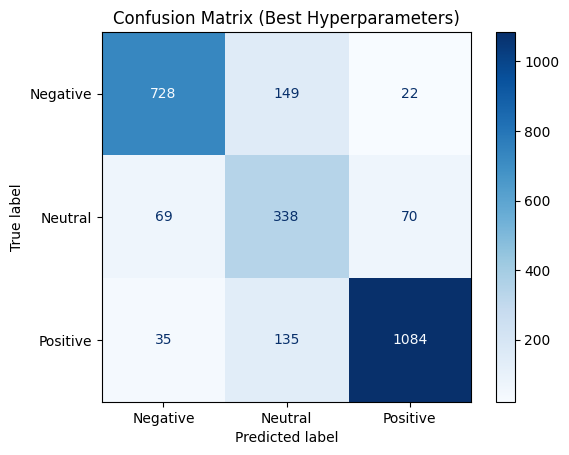

In [25]:
# Evaluation
best_hy_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in best_hy_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = best_hy_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nEvaluation Results with Best Hyperparameters:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Best Hyperparameters)")
plt.show()